In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import torch
from neuralop.data.datasets.custom_darcy import CustomDarcyDataset, load_darcy_flow
import matplotlib.pyplot as plt
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

In [2]:
resolution = 64
tau = 3
alpha = 2

train_loader, test_loaders, data_processor = load_darcy_flow(
    root_dir="./data/",
    dataset_name='darcy',
    n_train=1000,
    n_tests=[50],
    batch_size=100,
    test_batch_sizes=[50],
    train_resolution=resolution,
    test_resolutions=[resolution],
    train_data_setting={'tau': tau, 'alpha': alpha, 'boundary': 'ZD', 'coeff_type': 'hard3'},
    test_data_settings=[{'tau': tau, 'alpha': alpha, 'boundary': 'ZD', 'coeff_type': 'hard3'}],
)

'darcy_hard3_ZD_3_2_train_64.pt' not existed.


Generating data/darcy_hard3_ZD_3_2_train_64.pt: 100%|██████████| 1000/1000 [01:01<00:00, 16.28it/s]


data/darcy_hard3_ZD_3_2_train_64.pt saved
'darcy_hard3_ZD_3_2_test_64.pt' not existed.


Generating data/darcy_hard3_ZD_3_2_test_64.pt: 100%|██████████| 50/50 [00:03<00:00, 15.74it/s]


data/darcy_hard3_ZD_3_2_test_64.pt saved
Loading test db for resolution 64 with 50 samples 


/home/jaeminseo/Documents/neuraloperator-main/neuralop/data/datasets/pt_dataset.py:127: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  x_train = x_train[train_input_indices]
/home/jaeminseo/Documents/neuraloperator-main/neuralop/data/datasets/pt_dataset.py:150: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  y_train = y_t

In [3]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

model = FNO(
    n_modes=(16, 16),
    hidden_channels=64,
    in_channels=1,
    out_channels=1
)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 4769473 parameters.


In [4]:
n_epochs = 100
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [5]:
import wandb
from datetime import datetime

wandb.init(
    project='Samsung_Project_test',
    name=f'FNO_Fasttest_3'
)

wandb: Currently logged in as: tjwoals217 (tjwoals217-Chung-Ang University) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
trainer = Trainer(model=model, 
                  n_epochs=n_epochs,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=True,
                  eval_interval=1,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50] samples         on resolutions [64].


/home/jaeminseo/anaconda3/envs/PINN2/lib/python3.11/site-packages/tltorch/factorized_tensors/factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.__class__(self.tensor[indices])
/home/jaeminseo/Documents/neuraloperator-main/neuralop/layers/spectral_convolution.py:486: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_vari

Raw outputs of shape torch.Size([100, 1, 64, 64])
[0] time=1.11, avg_loss=2.3484, train_err=234.8377
Eval: 64_h1=2.8475, 64_l2=2.2301
[1] time=0.75, avg_loss=1.1796, train_err=117.9617
Eval: 64_h1=1.1880, 64_l2=2.1112
[2] time=0.76, avg_loss=0.9623, train_err=96.2337
Eval: 64_h1=1.3062, 64_l2=1.8674
[3] time=0.76, avg_loss=0.9028, train_err=90.2817
Eval: 64_h1=1.1111, 64_l2=1.1806
[4] time=0.76, avg_loss=0.8287, train_err=82.8688
Eval: 64_h1=0.9846, 64_l2=0.8618
[5] time=0.77, avg_loss=0.6805, train_err=68.0507
Eval: 64_h1=0.7057, 64_l2=0.5704
[6] time=0.76, avg_loss=0.4878, train_err=48.7795
Eval: 64_h1=0.5855, 64_l2=0.4606
[7] time=0.75, avg_loss=0.4139, train_err=41.3894
Eval: 64_h1=0.5187, 64_l2=0.4016
[8] time=0.76, avg_loss=0.3613, train_err=36.1276
Eval: 64_h1=0.4855, 64_l2=0.3827
[9] time=0.76, avg_loss=0.3251, train_err=32.5110
Eval: 64_h1=0.4447, 64_l2=0.3599
[10] time=0.76, avg_loss=0.2971, train_err=29.7130
Eval: 64_h1=0.4104, 64_l2=0.3449
[11] time=0.77, avg_loss=0.2676, t

{'train_err': 2.9004485099434576,
 'avg_loss': 0.029004485099434575,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.7508525000012014,
 '64_h1': tensor(0.0434, device='cuda:2', dtype=torch.float64),
 '64_l2': tensor(0.0408, device='cuda:2', dtype=torch.float64)}

In [7]:
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


64_h1,█▄▄▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
64_l2,██▅▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss,██▄▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
time,▆▆▇▆▇▃▄▁▇▃▆▆▁▇▄█▃▇▅▂▁▇▆▁▁▅▆▆▂▆▆▄▇▅▅▇▄▃▇▁
train_err,█▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
64_h1,0.0434
64_l2,0.04077
avg_loss,0.029
lr,0
time,0.75085


L2 error (0) : 0.03662143384603709
L2 error (1) : 0.02531585062503114
L2 error (2) : 0.02228488828634622


/home/jaeminseo/anaconda3/envs/PINN2/lib/python3.11/site-packages/tltorch/factorized_tensors/factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.__class__(self.tensor[indices])
/home/jaeminseo/Documents/neuraloperator-main/neuralop/layers/spectral_convolution.py:486: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_vari

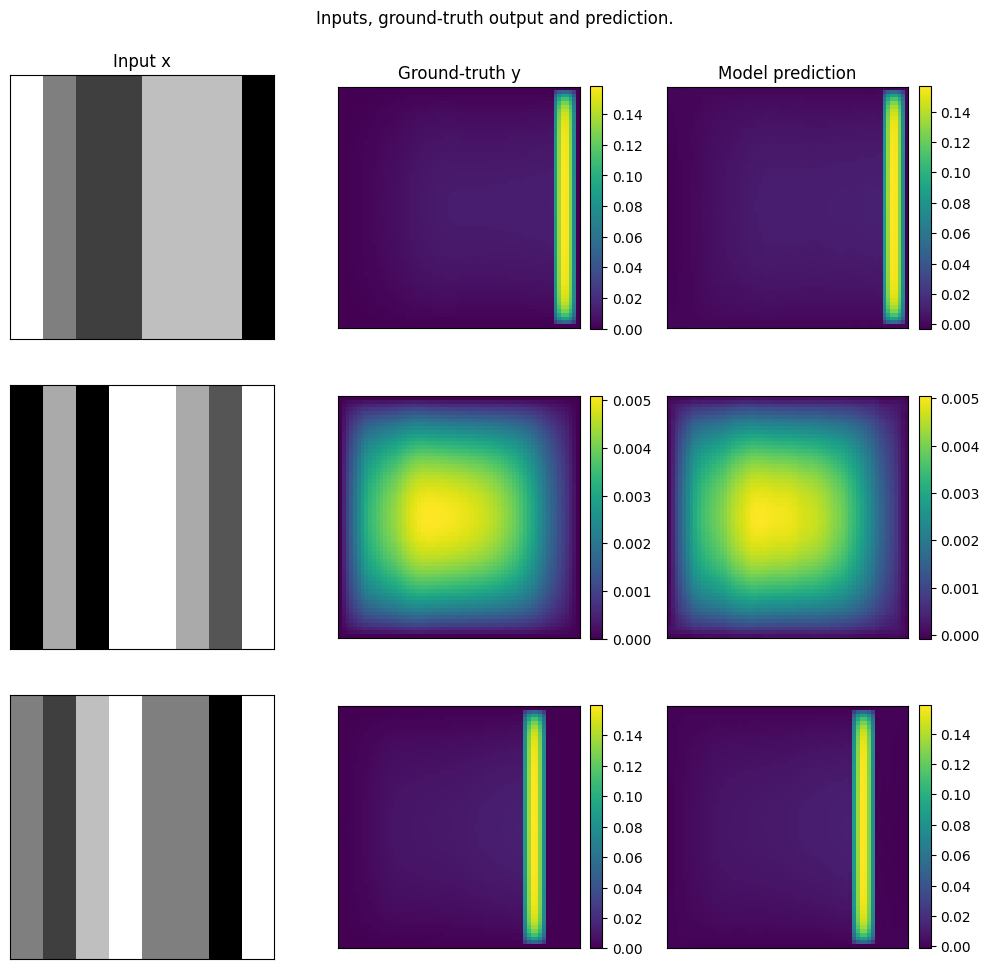

In [8]:
test_samples = test_loaders[64].dataset

# # Step 1: Compute global min and max for consistent color scaling
# vmin, vmax = float('inf'), float('-inf')
# for index in range(3):
#     data = test_samples[index]
#     data = data_processor.preprocess(data, batched=False)

#     x = data['x']
#     y = data['y']
#     out = model(x.unsqueeze(0))

#     y = data_processor.out_normalizer.inverse_transform(y).squeeze().detach()
#     out = data_processor.out_normalizer.inverse_transform(out).squeeze().detach()

#     vmin = min(vmin, y.min().item(), out.min().item())
#     vmax = max(vmax, y.max().item(), out.max().item())

# Step 2: Plot with consistent vmin/vmax and add colorbars
fig = plt.figure(figsize=(10, 10))

for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x'].to(device)
    y = data['y'].to(device)
    out = model(x.unsqueeze(0)).squeeze().detach()

    # y = data_processor.out_normalizer.inverse_transform(y)
    out = data_processor.out_normalizer.inverse_transform(out)

    # Input x
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    im = ax.imshow(x[0].cpu(), cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])
    
    # Ground-truth y
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    im = ax.imshow(y.squeeze().cpu())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Model prediction
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    im = ax.imshow(out.squeeze().cpu())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    print(f'L2 error ({index}) : {torch.norm(out - y) / torch.norm(y)}')

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
plt.show()